# Implied Correlation of Single-Tranche CDO — LHP + 1-Factor Gaussian

This notebook is part of the **Credit Risk Modeling** course in the MFE program at Chulalongkorn University.  
It explains each step and provides runnable code to reproduce the figures and results.

---

## Roadmap
**1. Nelson–Siegel yield curve & discount factors**  
**2. Coupon schedule construction (IMM-style) & day-count fractions**  
**3. LHP survival curve under 1-factor Gaussian (piecewise/exponential PD)**  
**4. Premium & protection legs (average-notional + Riemann grid)**  
**5. MTM vs $\rho$ sweep and implied correlation extraction**  
**6. Plots & exports (tables, implied-$\rho$ “smile”)**

---

## Case Description — Single-Tranche CDO Implied Correlation

- **Index:** iTraxx Europe S15 V1, 5Y  
- **Trade Date:** 28 Mar 2013  
- **Effective Date:** 29 Mar 2013 (T+1)  
- **Coupon Dates:** 20 Mar / 20 Jun / 20 Sep / 20 Dec (Modified Following; weekends roll to Monday; no holidays assumed)  
- **Day Count:** Actual/360  
- **Recovery:** $R = 40\\%$  
- **Tranches:** $[0,3], [3,6], [6,9], [9,12], [12,22]\\%$

**Quoted Running Spreads & Upfronts (from brief)**

| Tranche | Running Spread (bps) | Upfront |
|:------:|:---------------------:|:------:|
| [0,3]%   | 500 | 34.81% |
| [3,6]%   | 500 | 3.00%  |
| [6,9]%   | 300 | 0.75%  |
| [9,12]%  | 100 | 174 bps |
| [12,22]% | 100 | 80.5 bps |

---

## Parameters
- **Nelson–Siegel (cont. comp., annualized):**  
  $\beta_0=0.0385$, $\beta_1=-0.0376$, $\beta_2=-0.0423$, $\tau=2.82$
- **Credit model / numerics:**  
  $m=12$ (protection-leg grid per year), $\lambda=0.015$, $R=40\%$, $NC=125$

---

## Theory Recap (Notation)

- **Nelson–Siegel:**  
  $$\hat r(s)=\beta_0+\beta_1 \tfrac{\tau}{s}(1-e^{-s/\tau})+\beta_2\Big[\tfrac{\tau}{s}(1-e^{-s/\tau})-e^{-s/\tau}\Big]$$
- **Discount factor:** $$Z(0,s)=e^{-\hat r(s)\,s}$$
- **Tranche loss:**  
  $$L(t;K_1,K_2)=\dfrac{\max(L(t)-K_1,0)-\max(L(t)-K_2,0)}{K_2-K_1}$$
- **Premium leg (average notional):**  
  $$S\sum_i \tfrac{\Delta_{i-1,i}}{2}\,Z(0,t_i)\,\{Q_T(t_{i-1})+Q_T(t_i)\}$$
- **Protection leg (Riemann/trapezoid):**  
  $$\tfrac{1}{2}\sum_k [Z(0,s_{k-1})+Z(0,s_k)]\,\{Q_T(s_{k-1})-Q_T(s_k)\}$$
- **1-factor Gaussian LHP:** closed-form **expected loss** depends on asset correlation $\rho$ and marginal PD: $1-e^{-\lambda t}$;\
**Tranche survival:** $$Q_T(t)=\mathbb{E}[1-L(t;K_1,K_2)]$$.

---

## Objectives
1) Implement the **Gaussian 1-factor** credit model under **LHP**.  
2) Compute **tranche survival**
3) Price **premium** and **protection** legs as above.  
4) For tranches $[0,3],[3,6],[6,9],[9,12],[12,22]\%$ on **28-Mar-2013**, sweep $\rho\in\{0,0.01,\ldots,1.00\}$, find **implied $\rho$** where MTM is closest to zero, and plot the correlation “smile.”


## 1) Imports
Standard scientific stack and date utilities.

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm,multivariate_normal
import math
from datetime import datetime, timedelta


## 2) Nelson–Siegel term structure
Define NS parameters and a simple **modified Nelson–Siegel** function; compute rates on a yearly grid and plot.

[0.00090184 0.00208515 0.00391451 0.00604786 0.00827199 0.01045875
 0.01253546 0.01446507 0.01623286 0.01783775]


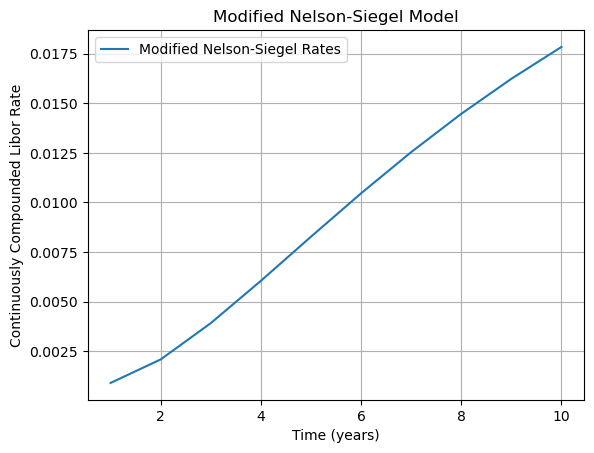

In [2]:

# Nelson-Siegel parameters
beta0 = 0.0385
beta1 = -0.0376
beta2 = -0.0423
tau = 2.82
# Time periods
time_periods0 = np.linspace(1, 10, 10)  # Time periods from 0 to 10 years given monthly subintervals
# Calculate continuously compounded Libor rates using modified Nelson-Siegel model
def modified_nelson_siegel_rates(s):
    return beta0 + beta1 * tau * (1/s) * (1 - np.exp(-s/tau)) + beta2 * (tau * (1/s) * (1 - np.exp(-s/tau)) - np.exp(-s/tau))
# Calculate rates
rates0 = modified_nelson_siegel_rates(time_periods0)
print(rates0)

# Plot the rates
plt.plot(time_periods0, rates0, label='Modified Nelson-Siegel Rates')
plt.xlabel('Time (years)')
plt.ylabel('Continuously Compounded Libor Rate')
plt.title('Modified Nelson-Siegel Model')
plt.legend()
plt.grid(True)
plt.show()


## 3) Discount factors
Define `discount_factor` and compute Z(0,t) from the NS curve; plot.

[0.99909856 0.99583838 0.98832516 0.97609883 0.9594837  0.93917589
 0.91599146 0.89072411 0.86407495 0.83662655]


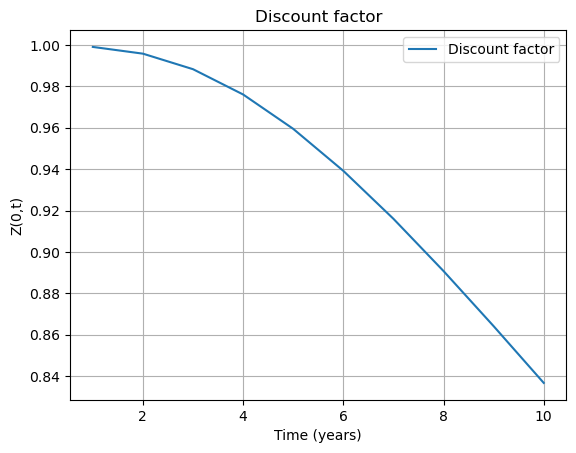

In [3]:

# Calculate continuously compounded Libor rates using modified Nelson-Siegel model
def discount_factor(t,s):
    return np.exp(-t*s)
# Calculate discount factor
df0 = discount_factor(time_periods0,rates0)
print(df0)
#Plot the rates
plt.plot(time_periods0, df0, label='Discount factor')
plt.xlabel('Time (years)')
plt.ylabel('Z(0,t)')
plt.title('Discount factor')
plt.legend()
plt.grid(True)
plt.show()


## 4) Base coupon calendar
Define IMM-style months (Mar/Jun/Sep/Dec) and enumerate dates between 2013–2016.

In [4]:

# Define the months and days
months_days = [(3, 20), (6, 20), (9, 20), (12, 20)]
# Define the range of years
start_year = 2013
end_year = 2016
# Create an array to store the dates
dates_array = []
# Generate the dates for each year
for year in range(start_year, end_year + 1):
    for month, day in months_days:
        date_string = f"{day:02d}-{month:02d}-{year}"
        dates_array.append(date_string)

# Adjust the date corresponding to the time period
dates_array = dates_array[1:len(dates_array)-2]


## 5) Coupon schedule from effective date (T+1) and accruals
Roll weekends to Monday, compute Actual/360 deltas and build the coupon time grid `time_periods1`.

In [5]:

# Compute delta and time period for premium term
eff_date = '29-03-2013'
eff_date1 = datetime.strptime(eff_date, '%d-%m-%Y')
convent_dates = []; deltas = []; time_periods1 = [0.0000001]
convent_dates = np.append(convent_dates, eff_date)
# Convert each date string to a datetime object and check the day of the week
for date_string in dates_array:
    # Convert the date string to a datetime object
    date = datetime.strptime(date_string, '%d-%m-%Y')
    # Get the day of the week (0=Monday, 1=Tuesday, ..., 6=Sunday)
    day_of_week = date.weekday()
    # If it's Saturday or Sunday, change the date to the nearest Monday
    if day_of_week == 5:  # Saturday
        date += timedelta(days=2)
    elif day_of_week == 6:  # Sunday
        date += timedelta(days=1)
    convent_dates = np.append(convent_dates, date.strftime('%d-%m-%Y'))
    difference = date - datetime.strptime(convent_dates[len(convent_dates)-2],'%d-%m-%Y')
    delta = float(difference.days/360)
    deltas = np.append(deltas, delta)
    maturity = delta + time_periods1[len(time_periods1)-1]
    time_periods1 = np.append(time_periods1, maturity)


## 6) Valuation horizon
Convert maturity date to year fraction from effective date; compute an integer number of monthly subintervals.

In [6]:

# compute time period for each maturity
dates_str = ["20 Jun 2016"]
days = []; denoms = []
# Convert each date string to a datetime object and check the day of the week
for date_string in dates_str:
    # Convert the date string to a datetime object
    dates = datetime.strptime(date_string, '%d %b %Y')
    # Get the day of the week (0=Monday, 1=Tuesday, ..., 6=Sunday)
    day_of_week = dates.weekday()
    # If it's Saturday or Sunday, change the date to the nearest Monday
    if day_of_week == 5:  # Saturday
        dates += timedelta(days=2)
    elif day_of_week == 6:  # Sunday
        dates += timedelta(days=1)
    difference1 = dates - eff_date1
    denom = math.ceil((difference1.days/360)*12)
    days = np.append(days, float(difference1.days/360))
    denoms = np.append(denoms, float(denom))
days = [float(x) for x in days]
denoms = [int(x) for x in denoms]


## 7) Tranche inputs and discount grids
Set recovery, quotes, tranche attachments/detachments; compute discount factors on coupon and protection grids.

In [7]:

# State all required values for computing h and MTM
R = 0.4
upfront_payment = [0.3481, 0.03, 0.0075, 0.0174, 0.00805]
spread_array = [0.05, 0.05, 0.03, 0.01, 0.01]
K1 = [0, 0.03, 0.06, 0.09, 0.12]
K2 = [0.03, 0.06, 0.09, 0.12, 0.22]
rates1 = modified_nelson_siegel_rates(time_periods1)
df1 = discount_factor(time_periods1, rates1)
time_periods = np.linspace(0.0000001, days[0], denoms[0]+1)
rates = modified_nelson_siegel_rates(time_periods)
df = discount_factor(time_periods, rates)
tranche_strings = ["tranche 0-3", "tranche 3-6", "tranche 6-9", "tranche 9-12","tranche 12-22"]
implied_corr = []; matrix_prem = np.zeros((101, 6)); matrix_prot = np.zeros((101, 6)); matrix_mtm = np.zeros((101, 6))


## 8) Bivariate normal CDF helper
Convenience wrapper over `scipy.stats.multivariate_normal.cdf`.

In [8]:

# Function to calculate the bivariate normal PDF
def bivariate_normal_cdf(x, y, mean, cov):
    """
    Compute the CDF of the bivariate normal distribution.
    Parameters:
    x (float): The x value up to which to integrate.
    y (float): The y value up to which to integrate.
    mean (array-like): The mean vector of the distribution.
    cov (array-like): The covariance matrix of the distribution.
    Returns:
    float: The CDF value.
    """
    # Create a multivariate normal distribution object
    mvn = multivariate_normal(mean, cov)
    # Compute the CDF up to the point (x, y)
    return mvn.cdf([x, y])


## 9) MTM across correlation (verbatim)
- **ρ = 0** baseline using univariate logic
- **ρ ∈ (0,1)** sweep using a covariance matrix per your code
- **ρ = 1** special-case
- Build MTM/premium/protection matrices, implied ρ, and plots

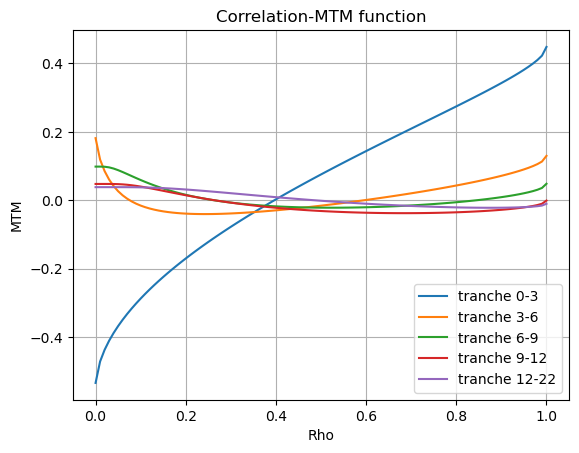

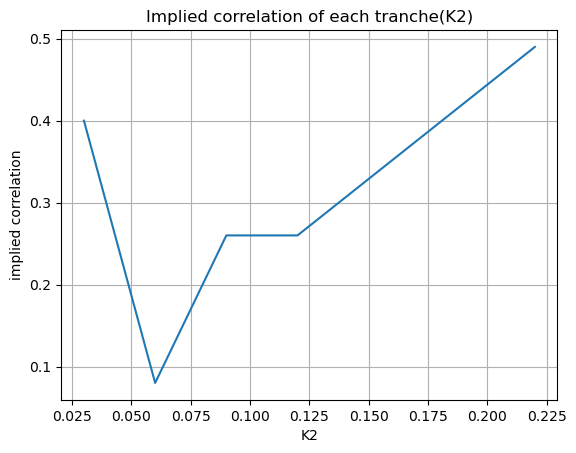

[0.4  0.08 0.26 0.26 0.49]


In [9]:
# compute Q
for j in range(1,len(K1)+1):
    # rho = 0
    # For the case when rho = 0, after simplification, The cdf will become the univariate version of standard normal
    # that take value of K / (1 - R) subtracted by another one that take -C(t) since CDF can be written as P(X<x, Y<y).
    # However, Y = -X in this instance, therefore  P(X<x, Y<y) = P(X<x, -X<y) = P(X<x, X>-y) = P(-y<X<x)= max(P(X<x) - P(X<-y),0)
    inv_K1R = -norm.ppf(K1[j - 1] / (1 - R), loc=0, scale=1); inv_K2R = -norm.ppf(K2[j - 1] / (1 - R), loc=0, scale=1);
    corr_v = []; protection_leg = []; premium_leg = []
    Q = [np.exp(-0.015 * time_periods1[1])]; PD = [1 - Q[0]];C = [norm.ppf(PD[0], loc=0, scale=1)]
    if -C[0] < inv_K1R:
        if -C[0] < inv_K2R:
            EL = ((norm.cdf(inv_K1R, loc=0, scale=1) - norm.cdf(-C[0], loc=0, scale=1)) - (
                    norm.cdf(inv_K2R, loc=0, scale=1) - norm.cdf(-C[0], loc=0, scale=1))) * (1 - R) / (
                         K2[j - 1] - K1[j - 1])
        else:
            EL = (norm.cdf(inv_K1R, loc=0, scale=1) - norm.cdf(-C[0], loc=0, scale=1)) * (1 - R) / (
                    K2[j - 1] - K1[j - 1])
    elif -C[0] < inv_K2R:
        EL = (norm.cdf(inv_K2R, loc=0, scale=1) - norm.cdf(-C[0], loc=0, scale=1)) * (1 - R) / (K2[j - 1] - K1[j - 1])
    else:
        EL = 0
    QT = [1 - EL]
    premium_v = []; protection_v = [];
    for i in range(1, len(time_periods1) - 1):
        Q = np.append(Q, np.exp(-0.015 * time_periods1[i + 1]))
        PD = np.append(PD, 1 - Q[i])
        C = np.append(C, norm.ppf(PD[i], loc=0, scale=1))
        if -C[i] < inv_K1R:
            if -C[i] < inv_K2R:
                EL = ((norm.cdf(inv_K1R, loc=0, scale=1) - norm.cdf(-C[i], loc=0, scale=1)) - (
                            norm.cdf(inv_K2R, loc=0, scale=1) - norm.cdf(-C[i], loc=0, scale=1))) * (1 - R) / (
                                 K2[j - 1] - K1[j - 1])
            else:
                EL = (norm.cdf(inv_K1R, loc=0, scale=1) - norm.cdf(-C[i], loc=0, scale=1)) * (1 - R) / (
                            K2[j - 1] - K1[j - 1])
        elif -C[i] < inv_K2R:
            EL = (norm.cdf(inv_K2R, loc=0, scale=1) - norm.cdf(-C[i], loc=0, scale=1)) * (1 - R) / (
                        K2[j - 1] - K1[j - 1])
        else:
            EL = 0
        QT = np.append(QT, 1 - EL)
        premium_v = np.append(premium_v, (spread_array[j - 1] / 2) * deltas[i] * df1[i + 1] * (QT[i - 1] + QT[i]))
    Q1 = [np.exp(-0.015 * time_periods[0])]; PD1 = [1 - Q1[0]]; C1 = [norm.ppf(PD1[0], loc=0, scale=1)]
    if -C1[0] < inv_K1R:
        if -C1[0] < inv_K2R:
            EL1 = ((norm.cdf(inv_K1R, loc=0, scale=1) - norm.cdf(-C1[0], loc=0, scale=1)) - (
                    norm.cdf(inv_K2R, loc=0, scale=1) - norm.cdf(-C1[0], loc=0, scale=1))) * (1 - R) / (
                          K2[j - 1] - K1[j - 1])
        else:
            EL1 = (norm.cdf(inv_K1R, loc=0, scale=1) - norm.cdf(-C1[0], loc=0, scale=1)) * (1 - R) / (
                    K2[j - 1] - K1[j - 1])
    elif -C[0] < inv_K2R:
        EL1 = (norm.cdf(inv_K2R, loc=0, scale=1) - norm.cdf(-C1[0], loc=0, scale=1)) * (1 - R) / (K2[j - 1] - K1[j - 1])
    else:
        EL1 = 0
    QT1 = [1 - EL1]
    for i in range(1, len(time_periods)):
        Q1 = np.append(Q1, np.exp(-0.015 * time_periods[i]))
        PD1 = np.append(PD1, 1 - Q1[i])
        C1 = np.append(C1, norm.ppf(PD1[i], loc=0, scale=1))
        if -C1[i] < inv_K1R:
            if -C1[i] < inv_K2R:
                EL1 = ((norm.cdf(inv_K1R, loc=0, scale=1) - norm.cdf(-C1[i], loc=0, scale=1)) - (
                        norm.cdf(inv_K2R, loc=0, scale=1) - norm.cdf(-C1[i], loc=0, scale=1))) * (1 - R) / (
                              K2[j - 1] - K1[j - 1])
            else:
                EL1 = (norm.cdf(inv_K1R, loc=0, scale=1) - norm.cdf(-C1[i], loc=0, scale=1)) * (1 - R) / (
                        K2[j - 1] - K1[j - 1])
        elif -C[0] < inv_K2R:
            EL1 = (norm.cdf(inv_K2R, loc=0, scale=1) - norm.cdf(-C1[i], loc=0, scale=1)) * (1 - R) / (
                    K2[j - 1] - K1[j - 1])
        else:
            EL1 = 0
        QT1 = np.append(QT1, 1 - EL1)
        protection_v = np.append(protection_v, ((df[i - 1] + df[i]) / 2) * (QT1[i - 1] - QT1[i]))
    v = upfront_payment[j - 1] + np.sum(premium_v) - np.sum(protection_v)
    premium_leg = np.append(premium_leg, upfront_payment[j - 1] + np.sum(premium_v))
    protection_leg = np.append(protection_leg, np.sum(protection_v))
    corr_v = np.append(corr_v, v)
    mu = [0, 0]; rhos = np.linspace(0.01,0.99,99);
    inv_K1R = -norm.ppf(K1[j-1]/(1-R),loc=0, scale=1); inv_K2R = -norm.ppf(K2[j-1]/(1-R),loc=0, scale=1)
    for rho in rhos:
        sigma = [[1, -np.sqrt(1 - rho)], [-np.sqrt(1 - rho), 1]]
        Q = [np.exp(-0.015 * time_periods1[1])]; PD = [1-Q[0]]
        C = [norm.ppf(PD[0],loc=0, scale=1)]; QT = [1 - ((bivariate_normal_cdf(inv_K1R, C[0], mu, sigma) - bivariate_normal_cdf(inv_K2R, C[0], mu, sigma))*(1-R)/(K2[j-1] - K1[j-1]))]
        premium_v = []; protection_v = [];
        for i in range(1,len(time_periods1)-1):
            Q = np.append(Q,np.exp(-0.015*time_periods1[i+1]))
            PD = np.append(PD, 1-Q[i])
            C = np.append(C,norm.ppf(PD[i],loc=0, scale=1))
            QT = np.append(QT, 1 - ((bivariate_normal_cdf(inv_K1R, C[i], mu, sigma) - bivariate_normal_cdf(inv_K2R, C[i], mu, sigma))*(1-R)/(K2[j-1] - K1[j-1])))
            premium_v = np.append(premium_v, (spread_array[j-1]/2) * deltas[i] * df1[i+1] * (QT[i-1] + QT[i]))
        Q1 = [np.exp(-0.015 * time_periods[0])]; PD1 = [1-Q1[0]]
        C1 = [norm.ppf(PD1[0],loc=0, scale=1)]; QT1 = [1 - ((bivariate_normal_cdf(inv_K1R, C1[0], mu, sigma) - bivariate_normal_cdf(inv_K2R, C1[0], mu, sigma))*(1-R)/(K2[j-1] - K1[j-1]))]
        for i in range(1, len(time_periods)):
            Q1 = np.append(Q1, np.exp(-0.015 * time_periods[i]))
            PD1 = np.append(PD1, 1 - Q1[i])
            C1 = np.append(C1, norm.ppf(PD1[i], loc=0, scale=1))
            QT1 = np.append(QT1, 1 - ((bivariate_normal_cdf(inv_K1R, C1[i], mu, sigma) - bivariate_normal_cdf(inv_K2R, C1[i], mu, sigma))*(1-R)/(K2[j-1] - K1[j-1])))
            protection_v = np.append(protection_v,((df[i-1] + df[i])/2) * (QT1[i-1] - QT1[i]))
        v = upfront_payment[j-1] + np.sum(premium_v) - np.sum(protection_v)
        premium_leg = np.append(premium_leg,upfront_payment[j-1] + np.sum(premium_v))
        protection_leg = np.append(protection_leg,np.sum(protection_v))
        corr_v = np.append(corr_v,v)
    # rho = 1
    # For the case where rho = 1, since both variables are independent, so the joint CDF is simply the product
    # of marginal CDF of each variable which are standard normal is this case.
    inv_K1R = -norm.ppf(K1[j - 1] / (1 - R), loc=0, scale=1); inv_K2R = -norm.ppf(K2[j - 1] / (1 - R), loc=0, scale=1)
    Q = [np.exp(-0.015 * time_periods1[1])]; PD = [1 - Q[0]]; C = [norm.ppf(PD[0], loc=0, scale=1)]
    QT = [1 - (norm.cdf(inv_K1R, loc=0, scale=1) * norm.cdf(C[0], loc=0, scale=1) - norm.cdf(inv_K2R, loc=0, scale=1) * norm.cdf(C[0], loc=0, scale=1)) * (1 - R) / (K2[j - 1] - K1[j - 1])]
    premium_v = []; protection_v = []
    for i in range(1, len(time_periods1) - 1):
        Q = np.append(Q, np.exp(-0.015 * time_periods1[i + 1]))
        PD = np.append(PD, 1 - Q[i])
        C = np.append(C, norm.ppf(PD[i], loc=0, scale=1))
        QT = np.append(QT, 1 - (norm.cdf(inv_K1R, loc=0, scale=1) * norm.cdf(C[i], loc=0, scale=1) - norm.cdf(inv_K2R, loc=0, scale=1) * norm.cdf(C[i], loc=0, scale=1)) * (1 - R) / (K2[j - 1] - K1[j - 1]))
        premium_v = np.append(premium_v, (spread_array[j - 1] / 2) * deltas[i] * df1[i + 1] * (QT[i - 1] + QT[i]))
    Q1 = [np.exp(-0.015 * time_periods[0])];
    PD1 = [1 - Q1[0]]; C1 = [norm.ppf(PD1[0], loc=0, scale=1)]
    QT1 = [1 - (norm.cdf(inv_K1R, loc=0, scale=1) * norm.cdf(C1[0], loc=0, scale=1) - norm.cdf(inv_K2R, loc=0, scale=1) * norm.cdf(C1[0], loc=0, scale=1)) * (1 - R) / (K2[j - 1] - K1[j - 1])]
    for i in range(1, len(time_periods)):
        Q1 = np.append(Q1, np.exp(-0.015 * time_periods[i]))
        PD1 = np.append(PD1, 1 - Q1[i])
        C1 = np.append(C1, norm.ppf(PD1[i], loc=0, scale=1))
        QT1 = np.append(QT1, 1 - (norm.cdf(inv_K1R, loc=0, scale=1) * norm.cdf(C1[i], loc=0, scale=1) - norm.cdf(inv_K2R, loc=0, scale=1) * norm.cdf(C1[i], loc=0, scale=1)) * (1 - R) / (K2[j - 1] - K1[j - 1]))
        protection_v = np.append(protection_v, ((df[i - 1] + df[i]) / 2) * (QT1[i - 1] - QT1[i]))
    v = upfront_payment[j - 1] + np.sum(premium_v) - np.sum(protection_v)
    premium_leg = np.append(premium_leg, np.sum(premium_v))
    protection_leg = np.append(protection_leg, np.sum(protection_v))
    corr_v = np.append(corr_v, v)
    rhos = np.linspace(0,1,101)
    corr_protv_matrix = np.column_stack((rhos, protection_leg))
    corr_premv_matrix = np.column_stack((rhos, premium_leg))
    corr_v_matrix = np.column_stack((rhos, corr_v))

    # print(corr_premv_matrix)
    # print(corr_protv_matrix)
    # print(corr_v_matrix)
    matrix_prem[:, 0] = rhos; matrix_prot[:, 0] = rhos; matrix_mtm[:, 0] = rhos
    matrix_prem[:,j] = premium_leg; matrix_prot[:,j] = protection_leg;  matrix_mtm[:,j] = corr_v
    index = float("inf"); index1 = float("inf")
    for k in range(1,len(corr_v_matrix[:,1])):
        if corr_v_matrix[k-1, 1] > 0 and corr_v_matrix[k, 1] < 0:
            if np.abs(corr_v_matrix[k-1, 1]) > np.abs(corr_v_matrix[k, 1]):
                index = k
            else:
                index = k-1
        elif corr_v_matrix[k-1, 1] < 0 and corr_v_matrix[k, 1] > 0:
            if np.abs(corr_v_matrix[k-1, 1]) > np.abs(corr_v_matrix[k, 1]):
                index1 = k
            else:
                index1 = k-1
        else:
            continue
    zero_index = min(index, index1)
    implied_corr = np.append(implied_corr, corr_v_matrix[zero_index, 0])

    #Plot the function
    plt.plot(rhos,corr_v, label=tranche_strings[j-1])
    plt.xlabel('Rho')
    plt.ylabel('MTM')
    plt.title('Correlation-MTM function')
    plt.legend()
    plt.grid(True)
plt.show()

plt.plot(K2, implied_corr)
plt.xlabel('K2')
plt.ylabel('implied correlation')
plt.title('Implied correlation of each tranche(K2)')
plt.grid(True)
plt.show()
print(implied_corr)

df = pd.DataFrame(matrix_prem); df1 = pd.DataFrame(matrix_prot); df2 = pd.DataFrame(matrix_mtm)
df3 = pd.DataFrame([time_periods0, rates0]); df4 = pd.DataFrame([time_periods0, df0]); df3 = df3.T; df4 = df4.T
df5 = pd.DataFrame(implied_corr)
# Export multiple DataFrames to different sheets
dfs = [df, df1, df2, df3, df4, df5]
# with pd.ExcelWriter('Value_report_HW2.xlsx') as writer:
#     startcol = 0
#     for df in dfs:
#         df.to_excel(writer, sheet_name='Sheet1', startrow=0, startcol=startcol, index=False)
#         startcol += len(df.columns) + 2  # Update startcol for the next DataFrame


# What the two plots show (and why)

## 1) “Correlation–MTM function”
**What is plotted**
- x-axis: tranche correlation ρ ∈ [0,1].
- y-axis: **MTM(ρ) = upfront + PV(premium-leg) − PV(protection-leg)** from your code.
  - MTM(ρ) > 0 ⇒ at that ρ the *quoted* payments (upfront + coupons) exceed the model’s expected protection payout → the quote looks **rich** to a protection buyer (**cheap** to a protection seller).
  - MTM(ρ) < 0 ⇒ the model expects more protection value than the quoted payments → **cheap** to a protection buyer (**rich** to a seller).

**Reading the shapes**
- **[0–3]% (equity)**: strongly **increasing** in ρ.  
  Intuition: higher correlation pushes loss mass to the *tail* (more “all-or-nothing” scenarios). Equity gets hit in those tails, so expected protection to equity rises with ρ → MTM(ρ) rises steeply (crossing from negative to positive).
- **[3–6]% (mezz)**: **U-shaped / non-monotone**.  
  At very low ρ, many small/independent defaults erode this tranche → higher protection value (MTM negative). As ρ rises, losses concentrate into either equity-only or very large events that jump over this band, so expected loss in this band first falls then rises slightly again near ρ≈1.
- **[6–9]%**: shallow **bowl-shape** around zero MTM for mid ρ.  
  Same diversification vs tail-risk story but weaker than 3–6%.
- **[9–12]%** and **[12–22]% (senior)**: near-flat or gently **increasing**.  
  Senior tranches benefit from **higher ρ** because losses either stay small (no hit) or leap far into the stack (only in very extreme scenarios). Hence expected protection value rises with ρ only mildly; MTM slopes up a bit.

**Why correlation does this**
- Low ρ ⇒ many idiosyncratic, *granular* losses: hurts mezzanine most; senior is rarely touched; equity loses steadily.
- High ρ ⇒ *lumpy* systemic outcomes: either almost no losses or a catastrophe. Equity gets hit more frequently/violently; senior is hit only in catastrophes (small probability but big jump); mezz can be bypassed in the extremes.

**Numerical/implementation notes**
- End behavior (very close to ρ=0 or ρ=1) and mild wiggles come from the chosen discount grid, Riemann approximation of the protection leg, and the specific upfront/coupon quotes used in your code. The overall qualitative shapes are the key signal.

---

## 2) “Implied correlation of each tranche (K2)”
**What is plotted**
- x-axis: **detachment** \(K2\) for the five tranches \([0,3], [3,6], [6,9], [9,12], [12,22]\%\).
- y-axis: **implied correlation** \( \rho^\* \) for each tranche, computed as the ρ where **MTM(ρ)=0** (the model’s PV of protection equals the quoted upfront+coupons).

**Your numbers**
- \([0,3]\%\) → **ρ ≈ 0.40**  
- \([3,6]\%\) → **ρ ≈ 0.08**  
- \([6,9]\%\) → **ρ ≈ 0.26**  
- \([9,12]\%\) → **ρ ≈ 0.26**  
- \([12,22]\%\) → **ρ ≈ 0.49**

**Interpretation (“correlation smile”)**
- **Ends high, middle low**: equity and senior require **higher** ρ to reconcile model PV with quotes; mezzanine requires **lower** ρ.  
  This is the classic **CDO correlation smile**:
  - **Equity** needs **high ρ** because tail clustering is what produces its large losses consistent with quotes.
  - **Senior** also points to **high ρ**: only under strong common-factor moves do losses reach the top of the stack.
  - **Mezz** sits in the diversification “sweet spot,” so quotes are matched at a **lower ρ**.

**Takeaway**
- The first figure shows *how* MTM varies with ρ tranche-by-tranche; the second collapses that to a single summary point per tranche (the zero-MTM ρ), revealing the well-known smile pattern across the capital structure.
